<center>
    <h1>
    Cats vs. Dogs
    </h1>
</center
<br>
<br>
<br>
<img src="./Header_Cats-vs-Dogs.png" width="100%" />

##### Context
Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately.

##### Content
The training archive contains 25,000 images of dogs and cats. 12,500 pictures of cats and 12,500 pictures of dogs.

[Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data).

## Libraries Imports

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from sklearn.decomposition import PCA

import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.image import imread
import warnings

warnings.filterwarnings("ignore")

path = "./data/train/"

## Data Proccecing

As a start, we have images of cats and dogs. these are random 3 images from our collection:

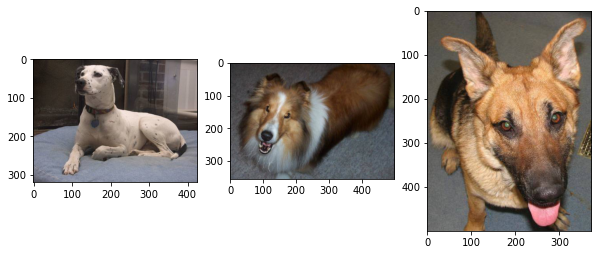

In [53]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))
    
for i in range(3):
    random_filename = random.choice([
        x for x in os.listdir(path)
        if os.path.isfile(os.path.join(path, x))
    ])
    image=imread(path + random_filename)
    globals()['a'+str(i + 1)].imshow(image)

To work with them we need to first proccess them to a format we can make models from. To do so, I will vectorize them, and standartize them to a uniformed size, color etc..

In [2]:
# reading and adding the images and their labels into np arrays
fileNames = os.listdir(path)
filesLength = len(fileNames)

isDogLabel = list() 
dataArray = np.ndarray((filesLength, 7500), dtype=np.uint8)
for i, fileName in enumerate(fileNames): 
    img = cv2.imread(path + fileName) 
    resizedImg = cv2.resize(img, (50,50)) # resizing to a uniform size
    if 'dog' in fileName: # labeling
        isDogLabel.append(1) 
    else:
        isDogLabel.append(0) 
    dataArray[i, :] = resizedImg.flatten()
    if i % 5000 == 0 : 
      print("Processed {} files of {} files.".format(i, filesLength))


Processed 0 files of 25000 files.
Processed 5000 files of 25000 files.
Processed 10000 files of 25000 files.
Processed 15000 files of 25000 files.
Processed 20000 files of 25000 files.


In [3]:
# inserting to a df
data = pd.DataFrame(dataArray, columns= [str(i+1) for i in range(dataArray.shape[1])])
labels = pd.DataFrame({"isDog": isDogLabel})
df = pd.concat([labels, data], axis=1) 
df.reset_index(drop=True, inplace=True)

,isDog,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500
0,0,92,169,208,100,177,216,104,182,225,...,2,0,2,2,0,2,2,0,2,2
1,0,43,43,39,64,58,55,36,40,35,...,71,47,53,70,52,57,75,20,26,39
2,0,53,45,38,61,47,41,64,54,47,...,166,52,150,165,2,183,185,10,183,187
3,0,217,222,221,220,225,224,237,235,235,...,205,208,210,210,218,220,219,207,212,215
4,0,72,109,137,83,120,148,48,87,115,...,96,82,105,120,59,91,102,64,90,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,107,144,148,110,147,151,113,150,154,...,178,132,168,178,134,169,179,135,170,180
24996,1,53,81,111,63,88,114,44,76,95,...,114,50,76,99,66,97,118,37,64,85
24997,1,45,48,53,50,53,58,51,53,54,...,111,134,175,213,27,76,117,126,171,217
24998,1,253,252,253,229,230,253,175,189,235,...,95,98,98,114,97,95,110,107,107,121


## Exploring the Data

In [62]:
print("Dataframe size:" , df.shape)

Dataframe size: (25000, 7501)


In [63]:
df

,isDog,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500
0,0,92,169,208,100,177,216,104,182,225,...,2,0,2,2,0,2,2,0,2,2
1,0,43,43,39,64,58,55,36,40,35,...,71,47,53,70,52,57,75,20,26,39
2,0,53,45,38,61,47,41,64,54,47,...,166,52,150,165,2,183,185,10,183,187
3,0,217,222,221,220,225,224,237,235,235,...,205,208,210,210,218,220,219,207,212,215
4,0,72,109,137,83,120,148,48,87,115,...,96,82,105,120,59,91,102,64,90,102


Excluding 'isDog' column, we can see we have 7501 features for each image. Each, describing one pixel.

Now we have a dataframe of our images, vectorized, standatized and ready to work on.
Let see how our vectors outcome:

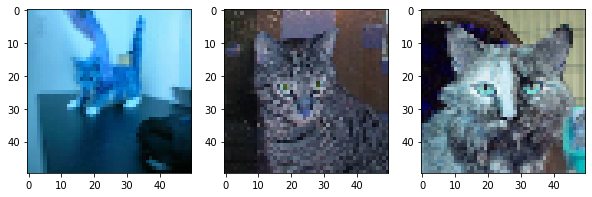

In [51]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))

for i in range(3):
    sample=np.reshape(df[df.columns[1:]].iloc[i].values/255,(50,50,3))
    globals()['a'+str(i + 1)].imshow(sample)

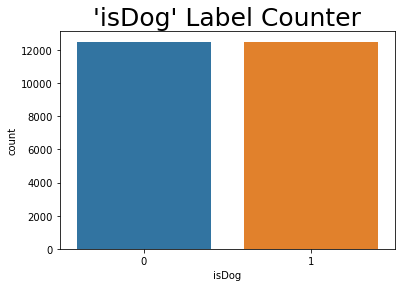

In [61]:
plt.title("'isDog' Label Counter", size=25)
fig = sns.countplot(df.isDog)

#  Modeling without Dimensionality Reduction

As a point of refrence, we will first model witout dimensionality reduction so we can later compare the diffrences.

## Splitting the Data

In [5]:
y = df.label
X = df.drop("isDog",axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Modeling with different classifiers

### KNeighborsClassifier

In [6]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
print("The KNN model score is: {:.2f}%".format(knn.score(X_test, y_test)*100))

The KNN model score is: 85.58%


### DecisionTreeClassifier

In [7]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt.score(X_test, y_test)
print("The DT model score is: {:.2f}%".format(dt.score(X_test, y_test)*100))

The DT model score is: 79.21%


### *--Ensamble models--*

### RandomForestClassifier

In [8]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc.score(X_test, y_test)
print("The RFC model score is: {:.2f}%".format(rfc.score(X_test, y_test)*100))

The RFC model score is: 87.86%


### *--Scores Overview Table--*

To get a clear overview, let's put it all in a summery table:

In [9]:
scores = [
    knn.score(X_test, y_test) * 100,
    dt.score(X_test, y_test) * 100,
    rfc.score(X_test, y_test) * 100,
]
scores_df = pd.DataFrame(
    data=scores,
    columns=["Score"],
    index=[
        "KNeighborsClassifier",
        "DecisionTreeClassifier",
        "RandomForestClassifier",
    ],
)
scores_df

,Score
KNeighborsClassifier,85.583333
DecisionTreeClassifier,79.208333
RandomForestClassifier,87.858333
